In [1]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm  # for progress bar
from sklearn.preprocessing import StandardScaler

load_dotenv()

# Load paths
allen_path = os.environ.get('ALLEN_CACHE')
rainbow_path = os.environ.get('RAINBOW_MOUSE_CACHE')
manifest_path = os.path.join(allen_path, "manifest.json")

# Load cache and session
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()
session = cache.get_session_data(sessions.index.values[0])

# Get natural scenes, remove blank (-1)
stimuli = session.stimulus_presentations
natural_scenes = stimuli[(stimuli.stimulus_name == "natural_scenes")]

# Get probe E
probe_id = session.probes[session.probes.description == 'probeE'].index.values[0]
lfp = session.get_lfp(probe_id)

# Get LFP timestamps and values
lfp_timestamps = lfp.time[1000:2000]  # shape (T,)
lfp_data = lfp.data # shape (95, T)
lfp_data = lfp.sel(time=slice(100,125))
lfp_data=np.array(lfp_data)
print(f"lfp_data shape: {lfp_data.shape}")
from rainbow_mouse.SIREN.lib import train_cebra_time
#train_cebra_time(lfp_data, 95, 100, 3, num_layers=3, omega_0=30, epochs=1000, batch_size=128, learning_rate=1e-3)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from rainbow_mouse.SIREN.lib import SIRENEncoder
import torch

def visualize_embedding_3d(data, encoder_path, input_dim, hidden_dim, output_dim,
                           num_layers=3, omega_0=30, title="3D Embedding of LFP"):
    encoder = SIRENEncoder(input_dim, hidden_dim, output_dim, num_layers, omega_0)
    encoder.load_state_dict(torch.load(encoder_path))
    encoder.eval()

    with torch.no_grad():
        embeddings = encoder(torch.tensor(data, dtype=torch.float32))

    # If output_dim > 3, use PCA to reduce
    if output_dim > 3:
        print(f"Reducing {output_dim}D embedding to 3D using PCA")
        embeddings = PCA(n_components=3).fit_transform(embeddings.numpy())
    else:
        embeddings = embeddings.numpy()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], color='mediumslateblue')
    ax.set_title(title)
    ax.set_xlabel("Latent 1")
    ax.set_ylabel("Latent 2")
    ax.set_zlabel("Latent 3")
    plt.tight_layout()
    plt.show()


/home/maria/RainbowMouse/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maria/RainbowMouse/.venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/maria/RainbowMouse/.venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


lfp_data shape: (31250, 95)


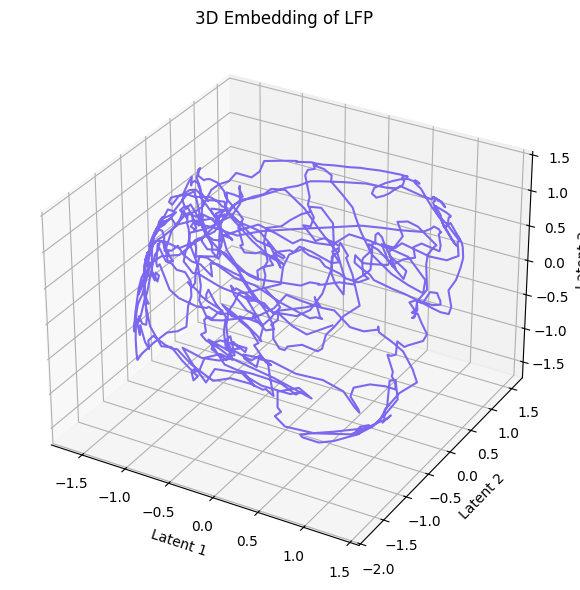

In [10]:
encoder_path='/home/maria/RainbowMouse/src/rainbow_mouse/SIREN/cebra_siren_encoder.pt'
input_dim=95
hidden_dim=100
output_dim=3

visualize_embedding_3d(lfp_data[1000:2000], encoder_path, input_dim, hidden_dim, output_dim,
                           num_layers=3, omega_0=30, title="3D Embedding of LFP")

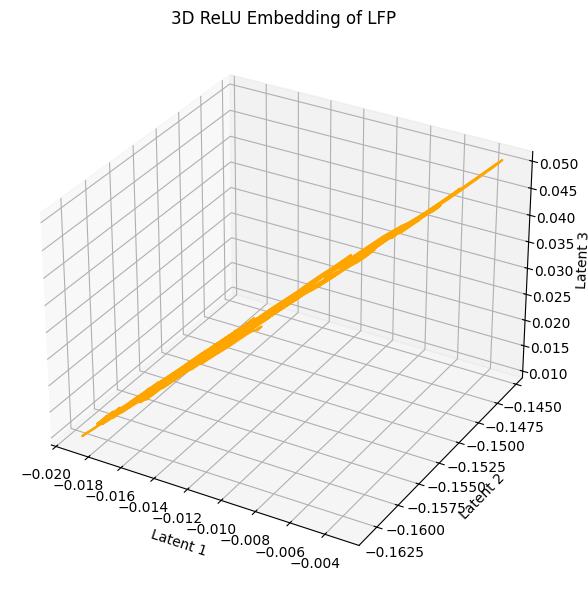

In [5]:
from rainbow_mouse.SIREN.lib import ReLUEncoder

def visualize_embedding_3d_relu(data, encoder_path, input_dim, hidden_dim, output_dim,
                                num_layers=3, title="3D ReLU Embedding of LFP"):
    encoder = ReLUEncoder(input_dim, hidden_dim, output_dim, num_layers)
    encoder.load_state_dict(torch.load(encoder_path))
    encoder.eval()

    with torch.no_grad():
        embeddings = encoder(torch.tensor(data, dtype=torch.float32))

    # Reduce to 3D if needed
    if output_dim > 3:
        print(f"Reducing {output_dim}D embedding to 3D using PCA")
        from sklearn.decomposition import PCA
        embeddings = PCA(n_components=3).fit_transform(embeddings.numpy())
    else:
        embeddings = embeddings.numpy()

    # Plotting
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], color='orange')
    ax.set_title(title)
    ax.set_xlabel("Latent 1")
    ax.set_ylabel("Latent 2")
    ax.set_zlabel("Latent 3")
    plt.tight_layout()
    plt.show()



visualize_embedding_3d_relu(lfp_data[:1000], "cebra_relu_encoder.pt", 95, 100, 3, num_layers=3)